This notebook will now have 

1. Regression of Behavior + GCamp 




In [ ]:
import numpy as np
import pandas as pd
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import statsmodels.api as sm 
import statsmodels.formula.api as smf



import seaborn as sns
import os

import rpy2.interactive as r
import datetime

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)

%load_ext jupyternotify


In [ ]:
%load_ext rpy2.ipython
%R library(rms)

In [ ]:
%%R -o f
test_data <- data.frame(time = c(1,1,1,2,2,2,3,3,3,4,4,4),
status = rep(c(1,0,2),4),
n = c(12,3,2,6,2,4,2,0,2,3,3,5))
# # fit a Kaplan-Meier and plot it
f <- ols(time ~ ., test_data)

# multiple event regression

In [1]:
df_corr_all = pd.read_csv("data/int_pc_qvals_gcamp_dms.csv", index_col = 0)

# first pull out the original gcamp. start with one mice (mice 9) for simplicity
data = pd.read_csv('./data/rachel_csv_6_19.csv', names = ['gcamp', 'TrialStart', 'NosePokeEnter', 'NosePokeExit', 'LeverPresentation',
                                                       'IpsLeverPress', 'ConLeverPress', 'CSplus', 'CSneg', 'RewardEnter',
                                                       'RewardExit', 'MouseID', 'RecordLoc', 'Session', 'HighProb'])
#         1 = VTA/SNc -> Dorsomedial Striatum
#         2 = VTA/SNc -> Nucleus Accumbens
#         3 = VTA/ SNc -> Dorsolateral Striatum (forgot i had these)
#         4 = VTA/ SNc -> Dorsomedial Striatum Cell Bodies
#         5 = GFP controls (DMS and NAc together)
data_g = pd.read_csv('./data/dan_table.csv')

data['gcamp'] = data_g['gcamp']

data['LeverPress'] = data['IpsLeverPress'] + data['ConLeverPress'] # add Lever Press in general 

# for gcamp (dt = dt of gcamp recordings)
dt = 15
LEN_BEFORE = dt
LEN_AFTER = dt * 2


NameError: name 'pd' is not defined

In [ ]:
# normalize

def normalize(x, mu, std):
    return (x - mu) / std


# normalizes values (gcamp or q values across mice)
def normalize_across_mice(df_src, values):

    for mouse_id in np.unique(df_src['MouseID']):
        mice_gcamp = df_src.loc[df_src['MouseID'] == mouse_id, values].values
        mice_mu = (np.mean(mice_gcamp))
        mice_std = (np.std(mice_gcamp))

        df_src.loc[df_src['MouseID'] == mouse_id, values] = normalize(mice_gcamp, mice_mu, mice_std)
    return df_src



In [ ]:
from rpy2.robjects import IntVector, Formula
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2 import robjects

base = importr('base')
rms = importr('rms')
stats = importr('stats')

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [7]:
data_src = normalize_across_mice(data[data["RecordLoc"] == 1], 'gcamp').reset_index()

recordloc = "DMS"
df_trial_src = normalize_across_mice(df_corr_all[df_corr_all['RecordLoc'] == recordloc].reset_index(), 'Q_ch_diff')



/anaconda3/envs/rpy/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
# building design matrix for different timelocks

event_names =  ['NosePokeEnter' , 'LeverPresentation', 'LeverPress']
design_matrix = np.zeros((len(data_src), len(event_names) * (LEN_BEFORE + LEN_AFTER)))
for event_i, event in enumerate(event_names):
    # shift the event indicator column accordingly for each event. 
    for shift_i, shift in enumerate(np.arange(-LEN_BEFORE,LEN_AFTER)):
        design_matrix[:, (event_i * (LEN_BEFORE + LEN_AFTER)) + shift_i] = data_src[event].shift(shift).fillna(0).values



# con/ips/reward previous

In [88]:
%%time
# buliding design matrix for different conditions


full_design_matrix = np.zeros((np.size(design_matrix, 0), np.size(design_matrix, 1) * 4))

# adding dummy 'trial_starts' for fencepost problem for final trial 
trial_starts = np.append(np.where(data_src['TrialStart'] == 1)[0], len(data_src))

for cond_i, (action, reward_last) in enumerate([('Con', 0.0), ('Con', 1.0), ('Ips', 0.0), ('Ips', 1.0)]):
    print("starting cond:", cond_i)
    cond = df_trial_src.index[(df_trial_src['Action'] == action) & (df_trial_src['Reward_last'] == reward_last)].values
    trial_starts_cond = trial_starts[cond]
    trial_ends_cond = trial_starts[cond + 1]
    
    cond_design_mask = np.zeros(len(data_src), dtype = bool)
    for (trial_starts_i, trial_ends_i) in zip(trial_starts_cond, trial_ends_cond):
        cond_design_mask[trial_starts_i:trial_ends_i] = True
    cond_design_matrix =  np.copy(design_matrix)
    cond_design_matrix[~cond_design_mask,:] = 0
    full_design_matrix[:, cond_i * np.size(design_matrix, 1) : (np.size(design_matrix, 1) * cond_i + np.size(design_matrix, 1))] = cond_design_matrix
    
        


starting cond: 0
starting cond: 1
starting cond: 2
starting cond: 3
CPU times: user 17.1 s, sys: 28.6 s, total: 45.7 s
Wall time: 42.7 s


In [89]:
%%time
# add intercept term
A = np.hstack((np.ones(len(data_src))[:, None], full_design_matrix))
df_reg = pd.DataFrame(full_design_matrix) # fit automatically adds an intercept here 

CPU times: user 6.55 s, sys: 14 s, total: 20.6 s
Wall time: 25.6 s


In [90]:
df_reg['gcamp'] = data_src['gcamp']
# df_reg['mouseInfo'] = data_src['MouseID'] # can use cluster on a vector 

In [ ]:
%%time
print('performing least squares')

# perform least squares
w_hat = np.linalg.inv(A.T @ A) @ A.T @ data_src['gcamp'].values

In [92]:
%%notify
print(datetime.datetime.now())
rdf_reg = pandas2ri.py2ri(df_reg)
print(datetime.datetime.now())

# took about 15 minutes for DMS 

2019-01-15 17:49:04.124245
2019-01-15 18:03:07.280759


<IPython.core.display.Javascript object>

In [93]:
%%notify
print(datetime.datetime.now())


fmla = Formula('gcamp ~ .')


fit = rms.ols(fmla, rdf_reg, x = True)
print(datetime.datetime.now())

# took 7 minutes for DMS_CB 
# took around 13 minutes for DMS 

2019-01-15 18:03:10.709603
2019-01-15 18:16:07.431538


<IPython.core.display.Javascript object>

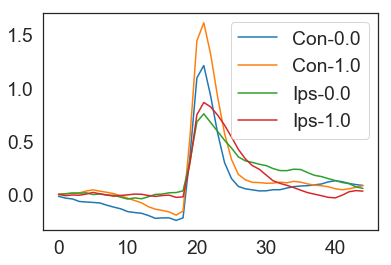

In [95]:
w_hat = fit[0]
_w_hat = w_hat[1:] # take out intercept

nosepoke_i = np.arange(0, len(_w_hat), 45 * 3)
leverpress_i = np.arange(45, len(_w_hat), 45 * 3)
choice_i = np.arange(90, len(_w_hat), 45 * 3)

event_i = leverpress_i 
for cond, cond_name in zip(event_i, ['Con-0.0', 'Con-1.0', 'Ips-0.0', 'Ips-1.0']):
    plt.plot(_w_hat[cond:(cond + 45)], label = cond_name)
plt.legend()

In [94]:
%%notify
print(datetime.datetime.now())

fit_adjusted2 = rms.robcov(fit, cluster=data_src['MouseID'].values) #, method = 'efron')
# took about 3 minutes for CB, DMS 

print(datetime.datetime.now())

2019-01-15 18:16:08.409580
2019-01-15 18:18:44.530928


<IPython.core.display.Javascript object>

In [69]:
data_src['MouseID'].values

array([1, 1, 1, ..., 7, 7, 7])

In [ ]:
fit

In [15]:
print(fit_adjusted2.names)

 [1] "coefficients"      "residuals"         "effects"          
 [4] "rank"              "fitted.values"     "assign"           
 [7] "qr"                "df.residual"       "var"              
[10] "stats"             "linear.predictors" "x"                
[13] "call"              "terms"             "Design"           
[16] "non.slopes"        "na.action"         "scale.pred"       
[19] "fail"              "sformula"          "orig.var"         
[22] "clusterInfo"      



In [96]:
coef = np.asarray(fit_adjusted2[0])
var = np.asarray(fit_adjusted2[8])

In [98]:
# pull the variables to put them in a dataframe 
varnames = list(np.repeat('NosePoke', 45))
varnames.extend(np.repeat('LeverPrez', 45))
varnames.extend(np.repeat('Choice', 45))
varnames = np.tile(varnames, 4)
varnames = np.insert(varnames, 0, 'Intercept')

time = list(np.tile(np.arange(-1, 2, 1/15), 3))
time = np.tile(time, 4)
time = np.insert(time, 0, -1)

cond = ['Intercept']
cond.extend(np.repeat(['Con-0.0', 'Con-1.0', 'Ips-0.0', 'Ips-1.0'], 45 * 3))

In [99]:
df_fit = pd.DataFrame(coef, columns = ['Estimate'])
df_fit['StdError'] = np.sqrt(np.diag(var))
df_fit['Variable'] = varnames
df_fit['Time'] = time
df_fit['Cond'] = cond

In [101]:
df_fit.to_csv("data/" + recordloc + "/multiple_event_reg_gcamp.csv")

In [ ]:
w_hat = np.asarray(fit_adjusted[0])
variance = np.asarray(fit_adjusted[])

import pickle
pickle.dump( w_hat, open( "data/" + recordloc + "/multiple_event_reg.p", "wb" ) )


# gcamp regression

In [9]:
%%notify
print(datetime.datetime.now())
Q_vals = 'Q_ch_diff'
# create design matrix with q vals

full_design_matrix = np.zeros((np.size(design_matrix, 0), np.size(design_matrix, 1) * 3))
trial_starts = np.append(np.where(data_src['TrialStart'] == 1)[0], len(data_src))

# q values, con, con * q values, ips, ips * q values 

# q values first 
q_val_cond = df_trial_src[Q_vals].values
trial_len = trial_starts[1:] - trial_starts[:-1]    

# have to add 0's to before the trial starts 
q_val_cond = np.hstack([np.zeros(trial_starts[0]), np.repeat(q_val_cond, trial_len)]) 



# block 1: Contra = 1, Ipsi = 0

cond = df_trial_src.index[(df_trial_src['Action'] == "Con")].values
trial_starts_cond = trial_starts[cond]
trial_ends_cond = trial_starts[cond + 1]

cond_design_mask = np.zeros(len(data_src), dtype = bool)
for (trial_starts_i, trial_ends_i) in zip(trial_starts_cond, trial_ends_cond):
    cond_design_mask[trial_starts_i:trial_ends_i] = True
cond_design_matrix =  np.copy(design_matrix)
cond_design_matrix[~cond_design_mask,:] = 0 # 0 out all ipsi trials 

full_design_matrix[:,  : np.size(design_matrix, 1)] = cond_design_matrix

# block 2: Q values * design_matrix 

full_design_matrix[:, np.size(design_matrix, 1): np.size(design_matrix, 1) * 2] = design_matrix * q_val_cond[:, None]

# block 3: Q values * cond_design_matrix 

full_design_matrix[:, np.size(design_matrix, 1) * 2: np.size(design_matrix, 1) * 3] = cond_design_matrix * q_val_cond[:, None]


# add intercept term
A = np.hstack((design_matrix, full_design_matrix))
print(datetime.datetime.now())

# takes 30 seconds for DMS_CB 

2019-01-15 20:23:14.328191
2019-01-15 20:23:55.731669


<IPython.core.display.Javascript object>

In [10]:
df_reg = pd.DataFrame(A) 
df_reg['gcamp'] = data_src['gcamp']

In [11]:
%%notify
print(datetime.datetime.now())
rdf_reg = pandas2ri.py2ri(df_reg)
print(datetime.datetime.now())

# takes about 9 minutes for CB

2019-01-15 20:23:56.153880
2019-01-15 20:41:07.733835


<IPython.core.display.Javascript object>

In [12]:
%%notify
print(datetime.datetime.now())


fmla = Formula('gcamp ~ .')


fit = rms.ols(fmla, rdf_reg, x = True)
print(datetime.datetime.now())

#  takes about 8 minutes for CB

2019-01-15 20:41:07.965685
2019-01-15 20:53:34.550119


<IPython.core.display.Javascript object>

In [13]:
%%notify
print(datetime.datetime.now())

fit_adjusted = rms.robcov(fit, cluster=data_src['MouseID'].values) #, method = 'efron')
# took about 3 minutes for CB 

print(datetime.datetime.now())



2019-01-15 20:53:35.130860
2019-01-15 20:56:42.811845


<IPython.core.display.Javascript object>

In [14]:
# take off added intercept 
coef = np.asarray(fit_adjusted[0])[1:]
var = np.asarray(fit_adjusted[8])[1:, 1:]

In [17]:
varnames = list(np.repeat('NosePoke', 45))
varnames.extend(np.repeat('LeverPrez', 45))
varnames.extend(np.repeat('Choice', 45))
varnames = np.tile(varnames, 4)

time = list(np.tile(np.arange(-1, 2, 1/15), 3))
time = np.tile(time, 4)


cond = (np.repeat(['Intercept', 'Action:Con', 'Q values', 'Interaction'], 45 * 3))

In [20]:
df_fit = pd.DataFrame(coef, columns = ['Estimate'])
df_fit['StdError'] = np.sqrt(np.diag(var))
df_fit['Variable'] = varnames
df_fit['Time'] = time
df_fit['Cond'] = cond

In [21]:
df_fit.to_csv("data/" + recordloc + "/multiple_event_reg_qvals.csv")

In [18]:
recordloc

'DMS'